In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy.io import wavfile
from scipy.signal import decimate

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
INPUT_LIB = './heartbeat/'
SAMPLE_RATE = 44100
CLASSES = ['artifact', 'normal', 'murmur']
CODE_BOOK = {x:i for i,x in enumerate(CLASSES)}   
NB_CLASSES = len(CLASSES)

### Load data

In [4]:
def load_wav_file(name, path):
  # fill in the code
  _, b = wavfile.read(path + name)
  assert _ == SAMPLE_RATE
  return b

In [10]:
def repeat_to_length(arr, length):
  # fill in the code
  # 가장 긴 data 길이로 모든 sample의 길이를 맞춰주는 부분
  # Repeats the numpy 1D array to given length, and makes datatype float"
  result = np.empty((length, ), dtype = 'float32')
  l = len(arr)
  pos = 0
  while pos + l <= length:
      result[pos:pos+l] = arr
      pos += l
  if pos < length:
      result[pos:length] = arr[:length-pos]
  return result

### Load data

In [35]:
# Load data
# fill in the code
df = pd.read_csv(INPUT_LIB + 'input.csv')
df['time_series'] = df['file_name'].apply(load_wav_file, path=INPUT_LIB + 'set_a/')
df['len_series'] = df['time_series'].apply(len)
MAX_LEN = max(df['len_series'])
df['time_series'] = df['time_series'].apply(repeat_to_length, length=MAX_LEN)

In [36]:
df.head()

,index,file_name,labels,time_series,len_series
0,0,artifact__201012172012.wav,0,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,1,artifact__201105040918.wav,0,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,2,artifact__201105041959.wav,0,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,3,artifact__201105051017.wav,0,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,4,artifact__201105060108.wav,0,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900


### Split the data

In [37]:
x_data = np.stack(df['time_series'].values, axis=0)
y_data = pd.get_dummies(df['labels'].values.tolist()).values

In [38]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['file_name'].values, test_size=0.25)

In [39]:
# print(f"X train shape: {x_train.shape}")
# print(f"X test  shape: {x_test.shape}")

In [40]:
# Downsalmping
# fill in the code

In [41]:
# print(f"X train shape: {x_train.shape}")
# print(f"X test  shape: {x_test.shape}")

In [42]:
#print(x_train.shape, np.std(x_train, axis=1).shape)
#print(np.std(x_train, axis=1))

#print((x_train/np.std(x_train, axis=1).reshape(-1,1)).shape)

#A = np.arange(20).reshape(5,4)
#B = np.arange(1,6)
#print('*A:')
#print(A)
#print('*B:')
#print(B)
# # print(A/B)
# print("* A/B: ")
#print(A/B.reshape(-1,1))

In [43]:
x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

In [44]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [45]:
print(f"X train shape: {x_train.shape}")
print(f"X test  shape: {x_test.shape}")

X train shape: (132, 396900, 1)
X test  shape: (44, 396900, 1)


### Define the model

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
def create_cnn(pkeep=0.1):
    '''
    Input: pkeep (dropout rate)
    return: model
    '''
    model = Sequential()
    model.add(Conv1D(filters=2, kernel_size=9, padding='same', activation='relu',input_shape=x_train.shape[1:])) # 132, 1551, 1 (132는 batch size라서 빼준다)
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))

    model.add(Conv1D(filters=2, kernel_size=9, padding='same', activation='relu'))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))

    model.add(Conv1D(filters=2, kernel_size=9, padding='same', activation='relu'))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))

    model.add(Conv1D(filters=2, kernel_size=9, padding='same', activation='relu'))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    model.add(Dropout(1-pkeep))
    model.add(Dense(units=3, activation = 'softmax'))
    print(model.summary())
    return model
model = create_cnn(0.5)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 396900, 2)         20        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99225, 2)         0         
 )                                                               
                                                                 
 conv1d_5 (Conv1D)           (None, 99225, 2)          38        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24807, 2)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 24807, 2)          38        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 6202, 2)         

### Train the model

In [48]:
# Set hyperparameters
pkeep = 0.5
batch_size = 8
epoch=100

In [49]:
# Create model and set loss function and optimizer
model = create_cnn(pkeep = pkeep)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 396900, 2)         20        
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 99225, 2)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 99225, 2)          38        
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 24807, 2)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 24807, 2)          38        
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 6202, 2)         

In [50]:
# Train the model 
# Return training results to `hists` variable
hists = model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
14/14 [==============================] - 4s 253ms/step - loss: 0.9911 - accuracy: 0.3524 - val_loss: 0.9612 - val_accuracy: 0.2593
Epoch 2/100
14/14 [==============================] - 3s 238ms/step - loss: 0.8968 - accuracy: 0.4381 - val_loss: 0.9192 - val_accuracy: 0.2963
Epoch 3/100
14/14 [==============================] - 3s 237ms/step - loss: 0.8631 - accuracy: 0.4095 - val_loss: 0.8974 - val_accuracy: 0.3333
Epoch 4/100
14/14 [==============================] - 3s 239ms/step - loss: 0.8410 - accuracy: 0.4476 - val_loss: 0.8808 - val_accuracy: 0.3333
Epoch 5/100
14/14 [==============================] - 3s 251ms/step - loss: 0.8019 - accuracy: 0.5619 - val_loss: 0.8683 - val_accuracy: 0.4074
Epoch 6/100
14/14 [==============================] - 4s 253ms/step - loss: 0.7683 - accuracy: 0.6190 - val_loss: 0.8548 - val_accuracy: 0.4074
Epoch 7/100
14/14 [==============================] - 3s 243ms/step - loss: 0.7203 - accuracy: 0.7238 - val_loss: 0.8405 - val_accuracy: 0.4074

### Plot the training result

In [51]:
loss = hists.history['loss']
val_loss = hists.history['val_loss']

acc = hists.history['accuracy']
val_acc = hists.history['val_accuracy']

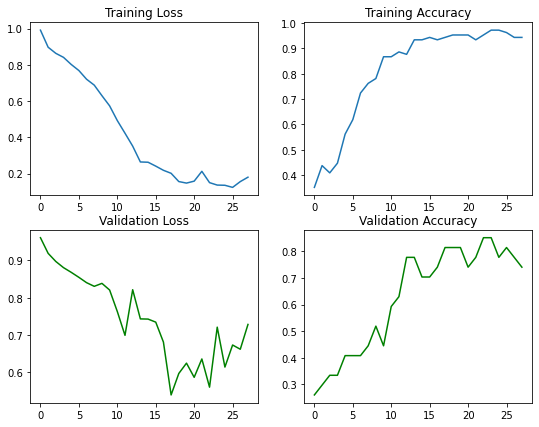

In [53]:
plt.figure(figsize=(9,7))

plt.subplot(221)
plt.title("Training Loss")
plt.plot(loss)

plt.subplot(222)
plt.title("Training Accuracy")
plt.plot(acc)

plt.subplot(223)
plt.title("Validation Loss")
plt.plot(val_loss, color='green')

plt.subplot(224)
plt.title("Validation Accuracy")
plt.plot(val_acc, color='green')

plt.show()

#Test the Model

2/2 [==============================] - 0s 106ms/step
Accuracy = 0.73


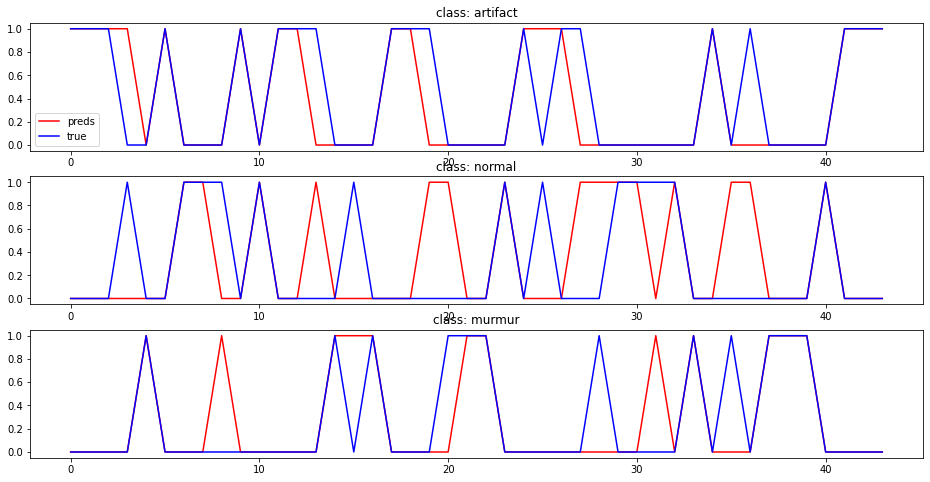

In [54]:
preds = tf.argmax(model.predict(x_test),1)
labels = tf.argmax(y_test,1)

accuracy_op = tf.keras.metrics.Accuracy()
test_acc = accuracy_op(preds, labels).numpy()

result = pd.get_dummies(preds).values
plt.figure(figsize=(16,8))
print(f"Accuracy = {test_acc:.2f}")
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(result[:,i], c='r')
    plt.plot(y_test[:,i], c='b')
    plt.title(f"class: {CLASSES[i]}")
    if i==0:
        plt.legend(['preds', 'true'])

### Plot the test result

In [55]:
mis_preds = [ i for i in range(len(labels)) if (preds[i].numpy() != labels[i].numpy())]

num = len(mis_preds)

print(f"the number of mis-prediction: {num}")

the number of mis-prediction: 12


In [56]:
# for i in range(num):
#     idx = mis_preds[i]
#     print(preds[idx].numpy() == labels[idx].numpy())

In [57]:
row = 4
col = int(np.ceil(num/row))

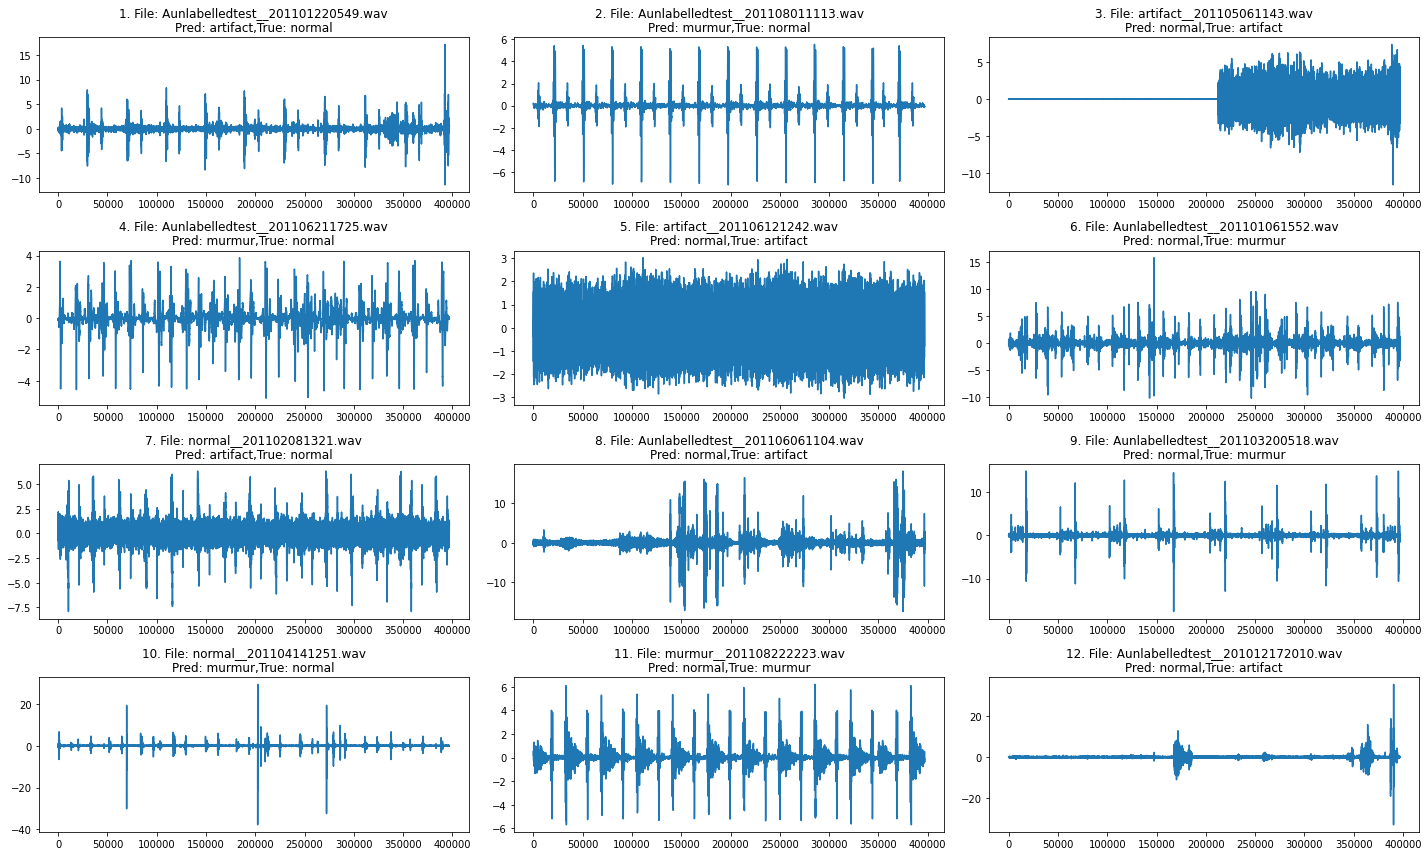

In [58]:
fig = plt.figure(figsize=(20, 12))

for i in range(num):
    plt.subplot(row, col, i+1)
    plt.plot(x_test[mis_preds[i]]) # mis_preds: [0, 10, 15]
    plt.title(f"{i+1}. File: {test_filenames[mis_preds[i]]}\n" 
              f"Pred: {CLASSES[preds[mis_preds[i]]]},"
              f"True: {CLASSES[labels[mis_preds[i]]]}")
    
fig.tight_layout()